# Guide to Model Stacking in Practice
*Interactive [article](https://gormanalysis.com/guide-to-model-stacking-i-e-meta-ensembling/)*


### Introduction

Stacking (also called meta ensembling) is a model ensembling technique used to combine information from multiple predictive models to generate a new model. Often times the stacked model (also called 2nd-level model) will outperform each of the individual models due its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. For this reason, stacking is most effective when the base models are significantly different. Here I provide a simple example and guide on how stacking is most often implemented in practice.


## Classify Dart Throwers

### Motivation

Suppose four people throw a combined 187 darts at a board. For 150 of those we get to see who threw each dart and where it landed. For the rest, we only get to see where the dart landed. Our task is to guess who threw each of the unlabelled darts based on their landing spot.

In [22]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
train = pd.read_csv("_Data/train.csv")
train = train.sort_values(['ID'])
test = pd.read_csv("_Data/test.csv")
test = test.sort_values(['ID'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
c_names = train['Competitor'].unique()
le.fit(c_names)
train.loc[:, 'Competitor_id'] = le.transform(train['Competitor'])
test.loc[:, 'Competitor_id'] = le.transform(test['Competitor'])

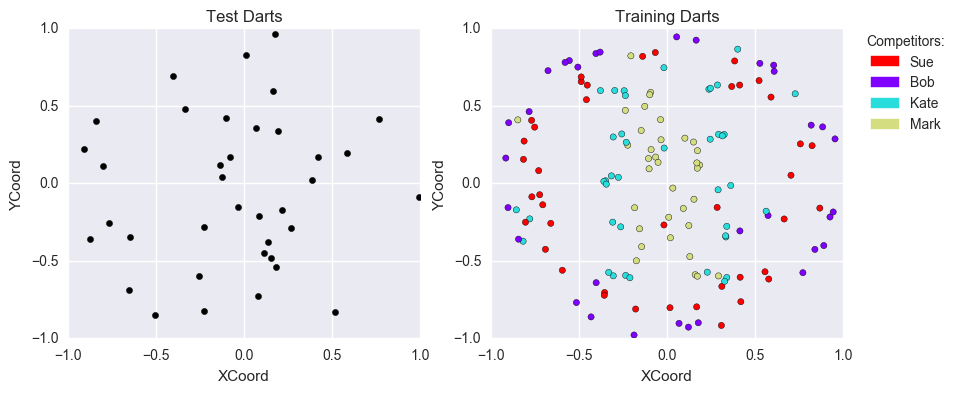

In [3]:
from matplotlib.patches import Patch

plt_cmap = plt.cm.get_cmap('rainbow')
c_ids = le.transform(c_names)
ll = len(c_names)-1
legend_handles = [Patch(color=plt_cmap(c*1.0/ll), label=l) for c, l in zip(c_ids, c_names)]

def plot_data(df, title='', colors='k'):
    plt.title(title)
    ax = plt.scatter(df['XCoord'], df['YCoord'], c=colors, cmap=plt_cmap)
    plt.xlabel("XCoord"); plt.ylabel("YCoord")
    plt.xlim((-1, 1)); plt.ylim((-1, 1))
    return ax
    
plt.figure(figsize=(10, 4))
plt.subplot(122)
ax = plot_data(train, "Training Darts", train['Competitor_id'])
plt.legend(
    title="Competitors:",
    handles=legend_handles,
    labels=c_names.tolist(),
    bbox_to_anchor=(1.05, 1), 
    loc=2, 
    borderaxespad=0.)
plt.subplot(121)
_ = plot_data(test, "Test Darts")

## K-Nearest Neighbors (Base Model1)

Let’s make a sad attempt at solving this classification problem using a K-Nearest Neighbors model. In order to select the best value for K, we’ll use 5-fold Cross-Validation combined with Grid Search where K=(1, 2, … 30). In pseudo code


1. Partition the training data into five equal size folds. Call these test folds
2. For K = 1, 2, … 10<br>
    2.1 For each test fold<br>
    2.1.1 Combine the other four folds to be used as a training fold<br>
    2.1.2 Fit a K-Nearest Neighbors model on the training fold (using the current value of K)<br>
    2.1.3 Make predictions on the test fold and measure the resulting accuracy rate of the predictions<br>
    2.2 Calculate the average accuracy rate from the five test fold predictions<br>
3. Keep the K value with the best average CV accuracy rate

With our fictitious data we find K=1 to have the best CV performance (67% accuracy). Using K=1, we now train a model on the entire training dataset and make predictions on the test dataset. Ultimately this will give us about 70% classification accuracy.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = train[['XCoord', 'YCoord']]
y = train['Competitor_id']

n_max_neighbors = 30
n_folds = 5

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, n_max_neighbors)}
clf = GridSearchCV(knn, params, cv=n_folds, scoring='accuracy', n_jobs=2)
_ = clf.fit(X, y)

Best parameters set found on development set: 
 {'n_neighbors': 1} 

Grid scores on development set: 

0.660 (+/-0.165) for {'n_neighbors': 1}
0.553 (+/-0.151) for {'n_neighbors': 2}
0.580 (+/-0.243) for {'n_neighbors': 3}
0.547 (+/-0.226) for {'n_neighbors': 4}
0.487 (+/-0.148) for {'n_neighbors': 5}
0.507 (+/-0.181) for {'n_neighbors': 6}
0.493 (+/-0.134) for {'n_neighbors': 7}
0.500 (+/-0.160) for {'n_neighbors': 8}
0.453 (+/-0.178) for {'n_neighbors': 9}
0.467 (+/-0.161) for {'n_neighbors': 10}
0.473 (+/-0.222) for {'n_neighbors': 11}
0.493 (+/-0.261) for {'n_neighbors': 12}
0.533 (+/-0.199) for {'n_neighbors': 13}
0.507 (+/-0.211) for {'n_neighbors': 14}
0.507 (+/-0.284) for {'n_neighbors': 15}
0.493 (+/-0.298) for {'n_neighbors': 16}
0.480 (+/-0.245) for {'n_neighbors': 17}
0.453 (+/-0.300) for {'n_neighbors': 18}
0.467 (+/-0.241) for {'n_neighbors': 19}
0.453 (+/-0.261) for {'n_neighbors': 20}
0.413 (+/-0.225) for {'n_neighbors': 21}
0.380 (+/-0.229) for {'n_neighbors': 22}
0.32

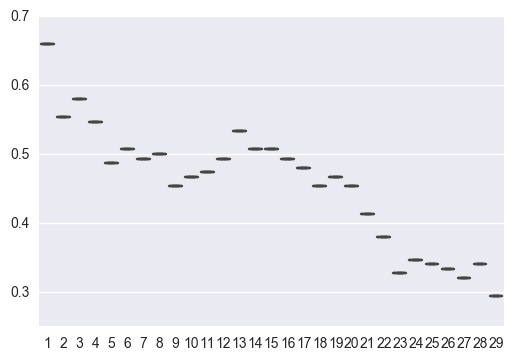

In [5]:
print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))
print("Grid scores on development set: \n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
param_res = clf.cv_results_['params']
for mean, std, params in zip(means, stds, param_res):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
plt.figure()
_ = sns.boxplot(x="param_n_neighbors", y="mean_test_score", data=clf.cv_results_)

In [6]:
from sklearn.metrics import accuracy_score

X_train = train[['XCoord', 'YCoord']]
y_train = train['Competitor_id']
X_test = test[['XCoord', 'YCoord']]
y_test = test['Competitor_id']

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Classsification accuracy on test data : %f" % accuracy)

Classsification accuracy on test data : 0.702703


## Support Vector Machine (Base Model2)

Now let’s make another sad attempt at solving the problem using a Support Vector Machine. Additionally, we’ll add a feature `DistFromCenter` that measures the distance each point lies from the center of the board to help make the data linearly separable. We get two hyper parameters to tune:

### Type
1. L2-regularized L2-loss support vector classification (dual)<br>
2. L2-regularized L2-loss support vector classification (primal)<br> 
3. L2-regularized L1-loss support vector classification (dual)<br>
4. Support vector classification by Crammer and Singer<br>
5. L1-regularized L2-loss support vector classification<br>


### Cost
Inverse of the regularization constant

The grid of parameter combinations we’ll test is the cartesian product of the 5 listed SVM types with cost values of (.01, .1, 1, 10, 100, 1000, 2000). That is


| Type | Cost |
|---|---|
| 1 | 0.01 |
| 1 | 0.1 |
| 1 | 1 |
| ... | ... |
| 5 | 100 |
| 5 | 1000 |
| 5 | 2000 |

Using the same CV + Grid Search approach we used for our K-Nearest Neighbors model, here we find the best hyper-parameters to be type = 4 with cost = 1000. Again, we use these parameters to train a model on the full training dataset and make predictions on the test dataset. This’ll give us about 61% CV classification accuracy and 78% classification accuracy on the test dataset.

In [7]:
train.loc[:, 'DistFromCenter'] = np.sqrt(train['XCoord']**2 + train['YCoord']**2)
test.loc[:, 'DistFromCenter'] = np.sqrt(test['XCoord']**2 + test['YCoord']**2)

In [8]:
from sklearn.svm import LinearSVC

X = train[['XCoord', 'YCoord', 'DistFromCenter']]
y = train['Competitor_id']

n_folds = 5

svc = LinearSVC(random_state=2016)
c_arr = [0.01, 0.1, 1, 100, 1000, 2000]
params = [
    # Type 1 : L2, L2, dual
    {"loss": ['squared_hinge'], "penalty": ['l2'], "dual": [True], 'C': c_arr}, 
    # Type 2 : L2, L2, primal
    {"loss": ['squared_hinge'], "penalty": ['l2'], "dual": [False], 'C': c_arr}, 
    # Type 3 : L2, L1, dual
    {"loss": ['hinge'], "penalty": ['l2'], "dual": [True], 'C': c_arr}, 
    # Type 4 : Crammer and Singer
    {'multi_class': ['crammer_singer'], 'C': c_arr}, 
    # Type 5 : L1, L2, primal
    {"loss": ['squared_hinge'], "penalty": ['l1'], "dual": [False], 'C': c_arr}, 
]

clf = GridSearchCV(svc, params, scoring='accuracy', cv=n_folds, n_jobs=2)
_ = clf.fit(X, y)

In [9]:
print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))

print("Grid scores on development set: \n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
param_res = clf.cv_results_['params']
for mean, std, params in zip(means, stds, param_res):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
X_train = train[['XCoord', 'YCoord', 'DistFromCenter']]
y_train = train['Competitor_id']
X_test = test[['XCoord', 'YCoord', 'DistFromCenter']]
y_test = test['Competitor_id']

svc = LinearSVC(**clf.best_params_, random_state=2016)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n Classification accuracy on test data : %f" % accuracy)

Best parameters set found on development set: 
 {'multi_class': 'crammer_singer', 'C': 2000} 

Grid scores on development set: 

0.393 (+/-0.097) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.01}
0.447 (+/-0.160) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.1}
0.540 (+/-0.232) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 1}
0.560 (+/-0.203) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 100}
0.420 (+/-0.238) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 1000}
0.380 (+/-0.112) for {'dual': True, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 2000}
0.393 (+/-0.097) for {'dual': False, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.01}
0.447 (+/-0.160) for {'dual': False, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.1}
0.540 (+/-0.232) for {'dual': False, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 1}
0.593 (+/-0.203) for {'dual': False, 'penalty': 'l2', 'loss': 'squared_hinge

## Stacking (Meta Ensembling)

Let’s take a look at the regions of the board each model would classify as Bob, Sue, Mark, or Kate.

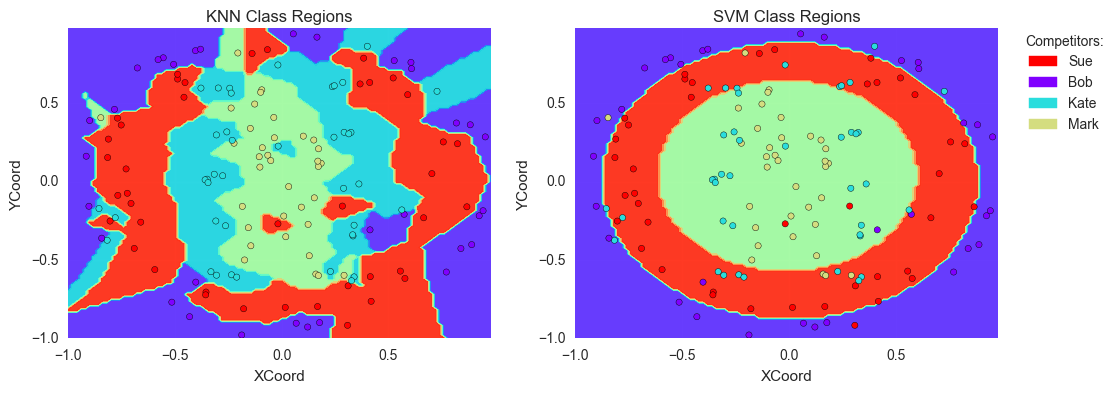

In [10]:
# create a mesh to plot in
x_min, x_max = -1, 1
y_min, y_max = -1, 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
dd = np.sqrt(xx**2 + yy**2)

def plot_results(xx, yy, Z, df):
    plt.contourf(xx, yy, Z, cmap=plt_cmap, alpha=0.95)
    plt.xlabel('XCoord')
    plt.ylabel('YCoord')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(df['XCoord'], df['YCoord'], c=df['Competitor_id'], cmap=plt_cmap)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('KNN Class Regions')
# Plot KNN
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plot_results(xx, yy, Z, train)

plt.subplot(122)
plt.title('SVM Class Regions')
# Plot SVN
Z = svc.predict(np.c_[xx.ravel(), yy.ravel(), dd.ravel()])
Z = Z.reshape(xx.shape)
plot_results(xx, yy, Z, train)
_ = plt.legend(
    title="Competitors:",
    handles=legend_handles,
    labels=c_names.tolist(),
    bbox_to_anchor=(1.05, 1), 
    loc=2, 
    borderaxespad=0.)

Unsurprisingly, the SVM does a good job at classifying Bob’s throws and Sue’s throws but does poorly at separating Kate’s throws and Mark’s throws. The opposite appears to be true for the K-nearest neighbors model. HINT: Stacking these models will probably be fruitful.

There are a few schools of thought on how to actually implement stacking. Here’s my personal favorite applied to our example problem:

**1. Partition the training data into five test folds**

**2. Create a dataset called `train_meta` with the same row Ids and fold Ids as the training dataset, with empty columns M1 and M2. Similarly create a dataset called `test_meta` with the same row Ids as the test dataset and empty columns M1 and M2**

In [11]:
vis_cols = ['ID', 'XCoord', 'YCoord', 'M1', 'M2', 'Competitor', 'Competitor_id']
train_meta = train.copy()
train_meta['M1'] = np.nan
train_meta['M2'] = np.nan
train_meta = train_meta.sort_values(['ID'])
train_meta[vis_cols].head()

,ID,XCoord,YCoord,M1,M2,Competitor,Competitor_id
14,1,0.703672,0.052088,NaN,NaN,Sue,3
115,2,-0.402343,-0.641072,NaN,NaN,Bob,0
46,3,-0.138605,0.819174,NaN,NaN,Sue,3
92,4,-0.779409,-0.229319,NaN,NaN,Kate,1
116,5,-0.262871,-0.280714,NaN,NaN,Kate,1


In [12]:
test_meta = test.copy()
test_meta['M1'] = np.nan
test_meta['M2'] = np.nan
test_meta = test_meta.sort_values(['ID'])
test_meta[vis_cols].head()

,ID,XCoord,YCoord,M1,M2,Competitor,Competitor_id
0,6,0.064729,0.356983,NaN,NaN,Mark,2
1,12,-0.766731,-0.255876,NaN,NaN,Sue,3
2,22,0.182282,-0.540976,NaN,NaN,Mark,2
3,34,-0.908910,0.223945,NaN,NaN,Bob,0
4,47,0.992230,-0.085550,NaN,NaN,Bob,0


**3. For each test fold `{Fold1, Fold2, … Fold5}`**

**3.1 Combine the other four folds to be used as a training fold**

**3.2 For each base model**

    M1: K-Nearest Neighbors (k = 1)
    M2: Support Vector Machine (type = 4, cost = 1000)
    
**3.2.1 Fit the base model to the training fold and make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model**

In [13]:
from sklearn.model_selection import KFold

X = train[['XCoord', 'YCoord', 'DistFromCenter']]
y = train['Competitor_id']

n_folds = 5
kf = KFold(n_splits=n_folds)

fold_id = 0
for train_index, test_index in kf.split(range(X.shape[0])):
    fold_id += 1
    print("-- Fold : %i" % (fold_id))
    train_index = X.index[train_index]
    test_index = X.index[test_index]
    X_train, y_train = X.loc[train_index, :], y.loc[train_index]
    X_test, y_test = X.loc[test_index, :], y.loc[test_index]   
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train[['XCoord', 'YCoord']], y_train)
    y_pred = knn.predict(X_test[['XCoord', 'YCoord']])    
    train_meta.loc[test_index, 'M1'] = y_pred
    
    svc = LinearSVC(multi_class='crammer_singer', C=1000)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    train_meta.loc[test_index, 'M2'] = y_pred
    
train_meta[vis_cols].tail()

-- Fold : 1
-- Fold : 2
-- Fold : 3
-- Fold : 4
-- Fold : 5


,ID,XCoord,YCoord,M1,M2,Competitor,Competitor_id
143,181,-0.331310,-0.574453,1.0,3.0,Kate,1
59,182,0.054601,0.944703,0.0,0.0,Bob,0
71,183,-0.210753,-0.609052,1.0,3.0,Kate,1
144,186,-0.855609,-0.170968,0.0,0.0,Kate,1
122,187,-0.728795,0.081992,3.0,3.0,Sue,3


In [14]:
train_meta[vis_cols].head()

,ID,XCoord,YCoord,M1,M2,Competitor,Competitor_id
14,1,0.703672,0.052088,3.0,3.0,Sue,3
115,2,-0.402343,-0.641072,3.0,3.0,Bob,0
46,3,-0.138605,0.819174,2.0,3.0,Sue,3
92,4,-0.779409,-0.229319,3.0,3.0,Kate,1
116,5,-0.262871,-0.280714,1.0,2.0,Kate,1


**4. Fit each base model to the full training dataset and make predictions on the test dataset. Store these predictions inside `test_meta`**

In [15]:
X_train = train[['XCoord', 'YCoord']]
X_test = test[['XCoord', 'YCoord']]
y_train = train['Competitor_id']

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)    
test_meta.loc[:, 'M1'] = y_pred

X_train = train[['XCoord', 'YCoord', 'DistFromCenter']]
X_test = test[['XCoord', 'YCoord', 'DistFromCenter']]

svc = LinearSVC(multi_class='crammer_singer', C=1000, random_state=2016)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
test_meta.loc[:, 'M2'] = y_pred

In [16]:
test_meta[vis_cols].head()

,ID,XCoord,YCoord,M1,M2,Competitor,Competitor_id
0,6,0.064729,0.356983,2,2,Mark,2
1,12,-0.766731,-0.255876,1,3,Sue,3
2,22,0.182282,-0.540976,2,3,Mark,2
3,34,-0.908910,0.223945,0,0,Bob,0
4,47,0.992230,-0.085550,0,0,Bob,0


**5. Fit a new model, S (i.e the stacking model) to `train_meta`, using M1 and M2 as features. Optionally, include other features from the original training dataset or engineered features**

S: L1-regularized Logistic Regression with `cost = 100`. Fit to `train_meta`

In [17]:
from sklearn.linear_model import LogisticRegression

X_train = train_meta[['M1', 'M2']]
y_train = train_meta['Competitor_id']

lr = LogisticRegression(C=100)
_ = lr.fit(X_train, y_train)

**6. Use the stacked model S to make final predictions on `test_meta`**

In [18]:
X_test = test_meta[['M1', 'M2']]
y_test = test_meta['Competitor_id']

y_pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Stacked model classification accuracy : %f" % accuracy)

test_meta.loc[:, 'Pred'] = y_pred
test_meta.head()

Stacked model classification accuracy : 0.810811


,ID,XCoord,YCoord,Competitor,Competitor_id,DistFromCenter,M1,M2,Pred
0,6,0.064729,0.356983,Mark,2,0.362804,2,2,2
1,12,-0.766731,-0.255876,Sue,3,0.808300,1,3,3
2,22,0.182282,-0.540976,Mark,2,0.570861,2,3,3
3,34,-0.908910,0.223945,Bob,0,0.936093,0,0,0
4,47,0.992230,-0.085550,Bob,0,0.995911,0,0,0


The main point to take home is that we’re using the **predictions** of the base models as features (i.e. meta features) for the stacked model. So, the stacked model is able to discern where each model performs well and where each model performs poorly. It’s also important to note that the meta features in row `i` of `train_meta` are **not dependent** on the target value in row `i` because they were produced using information that excluded the `target_i` in the base models’ fitting procedure.

Alternatively, we could make predictions on the test dataset using each base model immediately after it gets fit to each test fold. In our case this would generate test-set predictions for five K-Nearest Neighbors models and five SVM models. Then we would average the predictions per model to generate our M1 and M2 meta features. One benefit to this is that it’s less time consuming than the first approach (since we don’t have to retrain each model on the full training dataset). It also helps that our train meta features and test meta features should follow a similar distribution. However, the test metas M1 and M2 are likely more accurate in the first approach since each base model was trained on the full training dataset (as opposed to 80% of the training dataset, five times in the 2nd approach).

### Stacked Model Hyper Parameter Tuning

So, how do you tune the hyper parameters of the stacked model? Regarding the base models, we can tune their hyper parameters using Cross-Validation + Grid Search just like we did earlier. It doesn’t really matter what folds we use, but it’s usually convenient to use the same folds that we use for stacking. Tuning the hyper parameters of the stacked model is where things get interesting. In practice most people (including myself) simply use Cross Validation + Grid Search using the same exact CV folds used to generate the Meta Features. There’s a subtle flaw to this approach – can you spot it?


Indeed, there’s a small bit of data leakage in our stacking CV procedure. Consider the 1st round of Cross Validation for the stacked model. We fit a model S to `{fold2, fold3, fold4, fold5}`, make predictions on `fold1` and evaluate performance. But the meta features in `{fold2, fold3, fold4, fold5}` are dependent on the target values in `fold1`. So, the target values we’re trying to predict are themselves embedded into the features we’re using to fit our model. This is leakage and in theory S could deduce information about the target values from the meta features in a way that would cause it to overfit the training data and not generalize well to out-of-bag samples. However, you have to work hard to conjure up an example where this leakage is significant enough to cause the stacked model to overfit. In practice, everyone ignores this theoretical hole (and frankly I think most people are unaware it even exists!).

### Stacking Model Selection and Features

How do you know what model to choose as the stacker and what features to include with the meta features? In my opinion, this is more of an art than a science. Your best bet is to try different things and familiarize yourself with what works and what doesn’t. Another question is, what (if any) other features should you include in for the stacking model in addition to the meta features? Again this is somewhat of an art. Looking at our example, it’s pretty evident that `DistFromCenter` plays a part in determining which model will perform well. The KNN appears to do better at classifying darts thrown near the center and the SVM model does better at classifying darts thrown away from the center. Let’s take a shot at stacking our models using Logistic Regression. We’ll use the base model predictions as meta features and `DistFromCenter` as an additional feature.

Sure enough the stacked model performs better than both of the base models – 75% CV accuracy and 86% test accuracy. Now let’s take a look at its classification regions overlaying the training data, just like we did with the base models.


In [19]:
from sklearn.svm import LinearSVC

X = train_meta[['M1', 'M2', 'DistFromCenter']]
y = train_meta['Competitor_id']

n_folds = 5

lr = LogisticRegression()
c_arr = [0.01, 0.1, 1, 100, 1000, 2000]
params = {"penalty": ['l2', 'l1'], 'C': c_arr}

clf = GridSearchCV(lr, params, scoring='accuracy', cv=n_folds, n_jobs=2)
_ = clf.fit(X, y)

In [20]:
print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))

print("Grid scores on development set: \n")
means = clf.cv_results_['mean_test_score'][:5]
stds = clf.cv_results_['std_test_score'][:5]
param_res = clf.cv_results_['params'][:5]
for mean, std, params in zip(means, stds, param_res):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
X_train = train_meta[['M1', 'M2', 'DistFromCenter']]
y_train = train_meta['Competitor_id']
X_test = test_meta[['M1', 'M2', 'DistFromCenter']]
y_test = test_meta['Competitor_id']

lr = LogisticRegression(**clf.best_params_)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n Classification accuracy on test data : %f" % accuracy)

Best parameters set found on development set: 
 {'penalty': 'l2', 'C': 1} 

Grid scores on development set: 

0.413 (+/-0.040) for {'penalty': 'l2', 'C': 0.01}
0.447 (+/-0.069) for {'penalty': 'l1', 'C': 0.01}
0.547 (+/-0.134) for {'penalty': 'l2', 'C': 0.1}
0.667 (+/-0.183) for {'penalty': 'l1', 'C': 0.1}
0.740 (+/-0.187) for {'penalty': 'l2', 'C': 1}

 Classification accuracy on test data : 0.837838


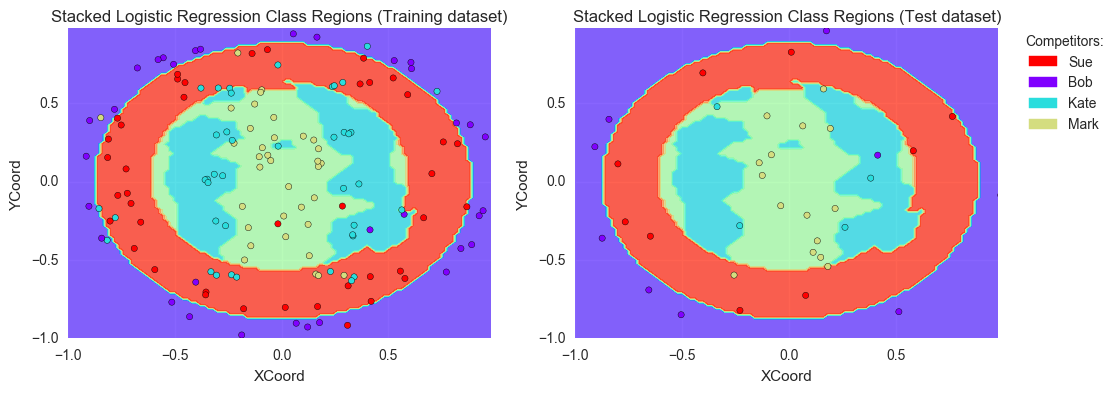

In [21]:
# create a mesh to plot in
x_min, x_max = -1, 1
y_min, y_max = -1, 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
dd = np.sqrt(xx**2 + yy**2)

m1 = knn.predict(np.c_[xx.ravel(), yy.ravel()])
m1 = m1.reshape(xx.shape)
m2 = svc.predict(np.c_[xx.ravel(), yy.ravel(), dd.ravel()])
m2 = m2.reshape(xx.shape)
Z = lr.predict(np.c_[m1.ravel(), m2.ravel(), dd.ravel()])
Z = Z.reshape(m1.shape)

def plot_results(xx, yy, Z, df):
    plt.contourf(xx, yy, Z, cmap=plt_cmap, alpha=0.75)
    plt.xlabel('XCoord')
    plt.ylabel('YCoord')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(df['XCoord'], df['YCoord'], c=df['Competitor_id'], cmap=plt_cmap)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Stacked Logistic Regression Class Regions (Training dataset)')
plot_results(xx, yy, Z, train)
plt.subplot(122)
plt.title('Stacked Logistic Regression Class Regions (Test dataset)')
plot_results(xx, yy, Z, test)
plt.legend(
    title="Competitors:",
    handles=legend_handles,
    labels=c_names.tolist(),
    bbox_to_anchor=(1.05, 1), 
    loc=2, 
    borderaxespad=0.)

The takeaway here is that the Logistic Regression Stacked Model captures the best aspects of each base model which is why it performs better than either base model in isolation.

## Stacking in Practice

To wrap this up, let’s talk about how, when, and why you might use stacking in the real world. Personally, I mostly use stacking in machine learning competitions on [Kaggle](https://www.kaggle.com/). In general, stacking produces small gains with a lot of added complexity – not worth it for most businesses. But Stacking is almost always fruitful so it’s almost always used in top Kaggle solutions. In fact, stacking is really effective on Kaggle when you have a team of people trying to collaborate on a model. A single set of folds is agreed upon and then every team member builds their own model(s) using those folds. Then each model can be combined using a single stacking script. This is great because it prevents team members from stepping on each others toes, awkwardly trying to stitch their ideas into the same code base.

One last bit. Suppose we have dataset with `(user, product)` pairs and we want to predict the probability that a user will purchase a given product if he/she is presented an ad with that product. An effective feature might be something like, using the training data, what percent of the products advertised to a user did he actually purchase in the past? So, for the sample `(user1, productA)` in the training data, we want to tack on a feature like `UserPurchasePercentage` but we have to be careful not to introduce leakage into the data. We do this as follows:

1. Split the training data into folds
2. For each test fold
    1. Identify the unique set of users in the test fold
    2. Use the remaining folds to calculate `UserPurchasePercentage` (percent of advertised products each user purchased)
    3. Map `UserPurchasePercentage` back to the training data via `(fold_id, user_id)`

Now we can use `UserPurchasePercentage` as a feature for our gradient boosting model (or whatever model we want). Effectively what we’ve just done is built a predictive model that predicts `user_i` will purchase `product_x` with probability based on the percent of advertised products he purchased in the past and used those predictions as a meta feature for our real model. This is a subtle but valid and effective form of stacking – one which I often do implement in practice and on Kaggle.